In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

df.head()

traffic_df = df[df['Objective'] == 'Traffic'].copy()
traffic_df.reset_index(drop=True, inplace=True)
traffic_df.head()


,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Traffic,actions:link_click,4505.81,Using ad set budget,4505.81,...,2.114411,243,71647.6,18.542428,3468,1788.29,1.299253,5850,0.770224,1501.936667
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Audience Network,Desktop,"Native, banner & interstitial",Traffic,actions:link_click,475.32,Using ad set budget,475.32,...,2.353069,111,249.0,4.282162,802,0.00,0.592668,13547,0.035087,475.320000
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,577.18,Using ad set budget,577.18,...,0.000000,14,0.0,41.227143,427,0.00,1.351710,2759,0.209199,577.180000
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Facebook,In-app,Facebook Reels,Traffic,actions:link_click,368.26,Using ad set budget,368.26,...,0.000000,3,755.1,122.753333,23,0.00,16.011304,2,184.130000,0.000000
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,3006.70,Using ad set budget,3006.70,...,0.873279,1023,59950.0,2.939101,8444,277.50,0.356075,160516,0.018731,150.335000


In [2]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

# Applying one-hot encoding
traffic_df_encoded = pd.get_dummies(traffic_df, columns=categorical_cols, drop_first=True)

traffic_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,Platforme_Facebook,Platforme_Instagram,Placement_Facebook Reels,Placement_Facebook Stories,Placement_Facebook profile feed,Placement_Feed,Placement_Instagram Stories,"Placement_Native, banner & interstitial",Device_In-app,Ad set budget type_Using ad set budget
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,4505.81,4505.81,7-day click or 1-day view,2025-01-14,2025-01-16,2025-03-25 00:00:00,...,False,True,False,False,False,True,False,False,False,True
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Traffic,actions:link_click,475.32,475.32,7-day click or 1-day view,2025-03-18,2025-03-18,2025-05-11 00:00:00,...,False,False,False,False,False,False,False,True,False,True
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Traffic,actions:link_click,577.18,577.18,7-day click or 1-day view,2024-08-15,2024-08-15,2024-09-04 00:00:00,...,False,False,False,False,False,False,False,True,True,True
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Traffic,actions:link_click,368.26,368.26,7-day click or 1-day view,2023-12-27,2023-12-27,2024-01-25 00:00:00,...,True,False,True,False,False,False,False,False,True,True
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,3006.70,3006.70,7-day click or 1-day view,2024-08-22,2024-08-22,Ongoing,...,False,False,False,False,False,False,False,True,True,True


In [3]:
traffic_df_encoded['Starts'] = pd.to_datetime(traffic_df_encoded['Starts'])
traffic_df_encoded['day'] = traffic_df_encoded['Starts'].dt.day
traffic_df_encoded['month'] = traffic_df_encoded['Starts'].dt.month
traffic_df_encoded['weekday'] = traffic_df_encoded['Starts'].dt.weekday

# Reapply log1p transformations for all relevant KPIs
traffic_df_encoded['log_CTR'] = np.log1p(traffic_df_encoded['CTR (all)'])
traffic_df_encoded['log_CPC'] = np.log1p(traffic_df_encoded['CPC (all) (USD)'])
traffic_df_encoded['log_spend'] = np.log1p(traffic_df_encoded['Amount spent'])
traffic_df_encoded['log_clicks'] = np.log1p(traffic_df_encoded['Clicks (all)'])
traffic_df_encoded['log_reach'] = np.log1p(traffic_df_encoded['Reach'])
traffic_df_encoded['log_impressions'] = np.log1p(traffic_df_encoded['Impressions'])

traffic_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,Ad set budget type_Using ad set budget,day,month,weekday,log_CTR,log_CPC,log_spend,log_clicks,log_reach,log_impressions
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,4505.81,4505.81,7-day click or 1-day view,2025-01-14,2025-01-16,2025-03-25 00:00:00,...,True,16,1,3,0.687282,0.060914,8.413345,11.180804,13.942121,15.797726
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Traffic,actions:link_click,475.32,475.32,7-day click or 1-day view,2025-03-18,2025-03-18,2025-05-11 00:00:00,...,True,18,3,1,1.023129,0.005833,6.166090,11.305397,14.032918,15.332883
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Traffic,actions:link_click,577.18,577.18,7-day click or 1-day view,2024-08-15,2024-08-15,2024-09-04 00:00:00,...,True,15,8,3,0.783902,0.020366,6.359885,10.241887,13.667811,14.673068
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Traffic,actions:link_click,368.26,368.26,7-day click or 1-day view,2023-12-27,2023-12-27,2024-01-25 00:00:00,...,True,27,12,2,1.038296,0.008989,5.911501,10.616045,13.689690,14.619941
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,3006.70,3006.70,7-day click or 1-day view,2024-08-22,2024-08-22,Ongoing,...,True,22,8,3,0.691969,0.005386,8.008931,13.229742,14.963486,17.837268


In [35]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
import joblib
import os

# Define the transformer
pt = PowerTransformer(method='yeo-johnson')

# List of KPI columns to transform
kpi_cols = ['CTR (all)', 'Clicks (all)']
log_kpi_cols = ['log_CTR', 'log_clicks']

traffic_df = traffic_df.dropna(subset=kpi_cols)

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
transformed = pt.fit_transform(traffic_df[kpi_cols])
transformed_cols = ['yj_' + col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') for col in kpi_cols]

# Add transformed columns
for i, col in enumerate(transformed_cols):
    traffic_df_encoded[col] = transformed[:, i]
    
#save the transformer
joblib.dump(pt, "models/traffic_power_transformer.joblib")

# Compare skewness
skew_data = pd.DataFrame({
    'Original': [skew(traffic_df[col]) for col in kpi_cols],
    'Log-Transformed': [skew(traffic_df_encoded[col]) for col in log_kpi_cols],
    'Yeo-Johnson': [skew(traffic_df_encoded[col]) for col in transformed_cols]

}, index=kpi_cols)

print(skew_data)

              Original  Log-Transformed  Yeo-Johnson
CTR (all)     3.428226         2.084258    -0.050609
Clicks (all)  3.848452         0.381460    -0.042223


In [36]:
traffic_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,month,weekday,log_CTR,log_CPC,log_spend,log_clicks,log_reach,log_impressions,yj_CTR_all,yj_Clicks_all
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,4505.81,4505.81,7-day click or 1-day view,2025-01-14,2025-01-16,2025-03-25 00:00:00,...,1,3,0.687282,0.060914,8.413345,11.180804,13.942121,15.797726,-0.408908,0.957970
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Traffic,actions:link_click,475.32,475.32,7-day click or 1-day view,2025-03-18,2025-03-18,2025-05-11 00:00:00,...,3,1,1.023129,0.005833,6.166090,11.305397,14.032918,15.332883,0.663228,1.068946
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Traffic,actions:link_click,577.18,577.18,7-day click or 1-day view,2024-08-15,2024-08-15,2024-09-04 00:00:00,...,8,3,0.783902,0.020366,6.359885,10.241887,13.667811,14.673068,-0.050782,0.085174
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Traffic,actions:link_click,368.26,368.26,7-day click or 1-day view,2023-12-27,2023-12-27,2024-01-25 00:00:00,...,12,2,1.038296,0.008989,5.911501,10.616045,13.689690,14.619941,0.701390,0.440848
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Traffic,actions:link_click,3006.70,3006.70,7-day click or 1-day view,2024-08-22,2024-08-22,Ongoing,...,8,3,0.691969,0.005386,8.008931,13.229742,14.963486,17.837268,-0.390468,2.649840


In [37]:
print(traffic_df_encoded.columns.tolist())


['Campaign name', 'Campaign Delivery', 'Objective', 'Result indicator', 'Ad set budget', 'Amount spent', 'Attribution setting', 'Date created', 'Starts', 'Ends', 'Reach', 'Impressions', 'Frequency', 'Results', 'Cost per results', 'Thruplays rate %', 'Result rate', 'Views', 'Clicks (all)', 'Purchases', 'CPC (all) (USD)', 'CTR (all)', 'Cost per 1,000 Accounts Center accounts reached (USD)', 'CPM (cost per 1,000 impressions) (USD)', '3-second video plays rate per impressions', 'Page engagement', 'Facebook follows or likes', 'Post comments', 'Post engagements', 'Post reactions', 'Post saves', 'Post shares', 'Photo views', 'Cost per Page engagement (USD)', 'Cost per follow or like (USD)', 'Cost per post engagement (USD)', '3-second video plays', 'ThruPlays', 'Video plays at 25%', 'Video plays at 50%', 'Video plays at 75%', 'Video plays at 95%', 'Video plays at 100%', 'Video average play time', 'Video plays', 'Cost per ThruPlay (USD)', 'Link clicks', 'Unique link clicks', 'CTR (link click-th

In [38]:
features_to_keep = [
    'yj_CTR_all', 'yj_Clicks_all',                   # Target
    'CPC (all) (USD)', 'Amount spent',       # Use spend, drop reach or impressions
    'Reach', 'Impressions',
    'day', 'month', 'weekday']

# Add one-hot encoded categorical columns dynamically
features_to_keep += [col for col in traffic_df_encoded.columns if any(p in col for p in ['Platforme_', 'Placement_', 'Device_', 'Ad set budget type_'])]

# Build final DataFrame
traffic_model_df = traffic_df_encoded[features_to_keep].dropna()

# Separate features and target
X_traffic = traffic_model_df.drop(['yj_CTR_all', 'yj_Clicks_all'], axis=1)
y_traffic = traffic_model_df[['yj_CTR_all', 'yj_Clicks_all']]


In [40]:
print("Feature set shape:", X_traffic.shape)
print("Target variable shape:", y_traffic.shape)
X_traffic.head()


Feature set shape: (108, 17)
Target variable shape: (108, 2)


,CPC (all) (USD),Amount spent,Reach,Impressions,day,month,weekday,Platforme_Facebook,Platforme_Instagram,Placement_Facebook Reels,Placement_Facebook Stories,Placement_Facebook profile feed,Placement_Feed,Placement_Instagram Stories,"Placement_Native, banner & interstitial",Device_In-app,Ad set budget type_Using ad set budget
0,0.062808,4505.81,1134974,7258805,16,1,3,False,True,False,False,False,True,False,False,False,True
1,0.005850,475.32,1242849,4560228,18,3,1,False,False,False,False,False,False,False,True,False,True
2,0.020575,577.18,862689,2357395,15,8,3,False,False,False,False,False,False,False,True,True,True
3,0.009030,368.26,881772,2235421,27,12,2,True,False,True,False,False,False,False,False,True,True
4,0.005401,3006.70,3151804,55799095,22,8,3,False,False,False,False,False,False,False,True,True,True


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_traffic, y_traffic, test_size=0.2, random_state=42
)


In [42]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(type(X_train), type(y_train))


X_train shape: (86, 17)
y_train shape: (86, 2)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [43]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 9. Define Models
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge())
}

In [44]:
best_model = None
best_score = -np.inf
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_CTR = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
    r2_CTR = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
    mae_CTR = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])

    rmse_Clicks = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))
    r2_Clicks = r2_score(y_test.iloc[:, 1], y_pred[:, 1])
    mae_Clicks = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])

    print(f"{name}")
    print(f"CTR - RMSE: {rmse_CTR:.4f} | MAE: {mae_CTR:.4f} | R²: {r2_CTR:.4f}")
    print(f"Clicks - RMSE: {rmse_Clicks:.4f} | MAE: {mae_Clicks:.4f} | R²: {r2_Clicks:.4f}")
    print("-" * 50)

    metrics_summary.append({
        "Model": name,
        "CTR RMSE": rmse_CTR,
        "CTR MAE": mae_CTR,
        "CTR R2": r2_CTR,
        "CLICKS RMSE": rmse_Clicks,
        "CLICKS MAE": mae_Clicks,
        "CLICKS R2": r2_Clicks
    })

    if r2_CTR + r2_Clicks > best_score:
        best_score = r2_CTR + r2_Clicks
        best_model = model
        best_name = name

Linear Regression
CTR - RMSE: 1.3539 | MAE: 0.8800 | R²: -0.3343
Clicks - RMSE: 0.8909 | MAE: 0.5436 | R²: 0.3732
--------------------------------------------------
Ridge Regression
CTR - RMSE: 1.1712 | MAE: 0.9415 | R²: 0.0015
Clicks - RMSE: 0.8108 | MAE: 0.5936 | R²: 0.4807
--------------------------------------------------
Random Forest
CTR - RMSE: 0.6421 | MAE: 0.5228 | R²: 0.6998
Clicks - RMSE: 0.3841 | MAE: 0.3057 | R²: 0.8835
--------------------------------------------------
Bayesian Ridge
CTR - RMSE: 1.1521 | MAE: 0.9239 | R²: 0.0338
Clicks - RMSE: 0.9569 | MAE: 0.7318 | R²: 0.2768
--------------------------------------------------


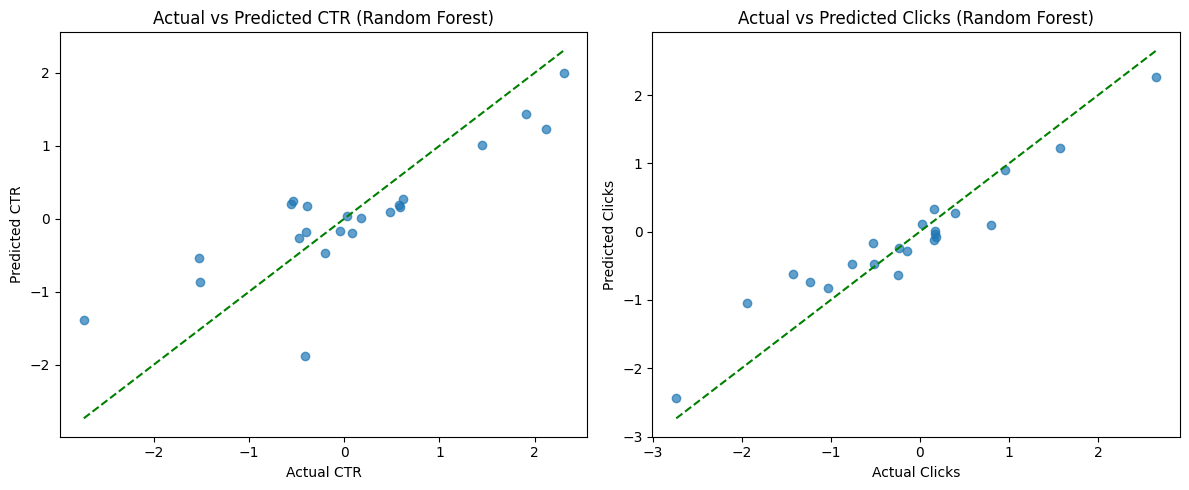

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 12. Actual vs Predicted Plot for Best Model
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test.iloc[:, 0], y_pred_best[:, 0], alpha=0.7)
plt.plot([y_test['yj_CTR_all'].min(), y_test['yj_CTR_all'].max()],
         [y_test['yj_CTR_all'].min(), y_test['yj_CTR_all'].max()], '--g')
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title(f"Actual vs Predicted CTR ({best_name})")

plt.subplot(1, 2, 2)
plt.scatter(y_test.iloc[:, 1], y_pred_best[:, 1], alpha=0.7)
plt.plot([y_test['yj_Clicks_all'].min(), y_test['yj_Clicks_all'].max()],
         [y_test['yj_Clicks_all'].min(), y_test['yj_Clicks_all'].max()], '--g')
plt.xlabel("Actual Clicks")
plt.ylabel("Predicted Clicks")
plt.title(f"Actual vs Predicted Clicks ({best_name})")

plt.tight_layout()
plt.show()

In [47]:
# 13. Cross-Validation for Best Model
cv_r2 = cross_val_score(best_model, X_traffic, y_traffic, scoring='r2', cv=5)
cv_rmse = np.sqrt(-cross_val_score(best_model, X_traffic, y_traffic, scoring='neg_mean_squared_error', cv=5))
cv_mae = -cross_val_score(best_model, X_traffic, y_traffic, scoring='neg_mean_absolute_error', cv=5)

In [49]:
print(f"""
### ✅ Traffic Campaign Modeling Summary

We tested 4 models to predict CTR and Clicks:

🔹 **Best Model:** {best_name}  
📈 CTR R²: {metrics_summary[2]['CTR R2']:.4f}  
📈 Clicks R²: {metrics_summary[2]['CLICKS R2']:.4f}  

✅ **Cross-Validation Results:**  
Avg R²: {np.mean(cv_r2):.4f}  
Avg RMSE: {np.mean(cv_rmse):.4f}  
Avg MAE: {np.mean(cv_mae):.4f}

The scatter plots confirm this model's predictions align closely with actual values.
""")


### ✅ Traffic Campaign Modeling Summary

We tested 4 models to predict CTR and Clicks:

🔹 **Best Model:** Random Forest  
📈 CTR R²: 0.6998  
📈 Clicks R²: 0.8835  

✅ **Cross-Validation Results:**  
Avg R²: 0.5672  
Avg RMSE: 0.6001  
Avg MAE: 0.4463

The scatter plots confirm this model's predictions align closely with actual values.



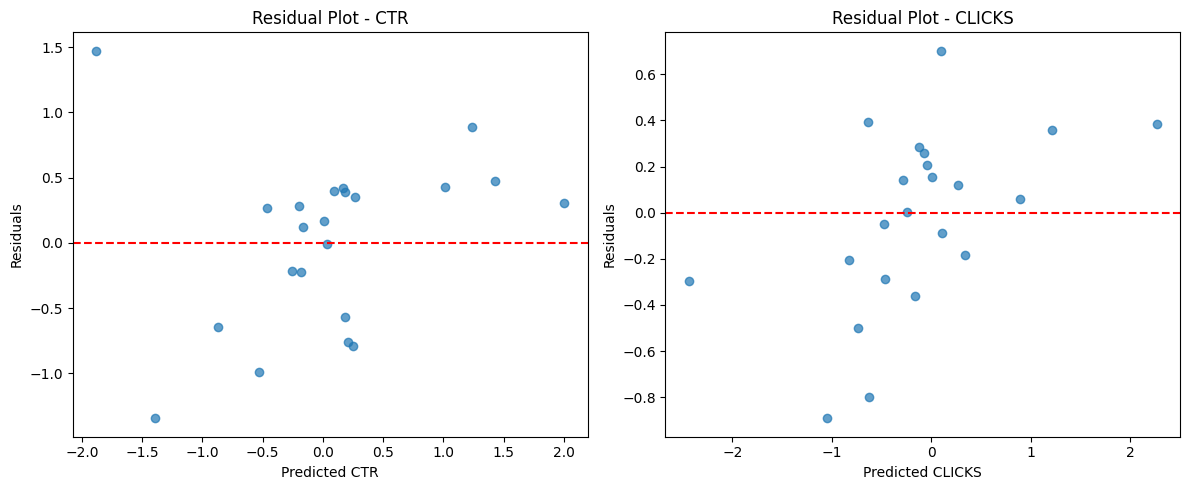

In [50]:
# 14. Residual Plot for Best Model
residuals_CTR = y_test.iloc[:, 0] - y_pred_best[:, 0]
residuals_CLICKS = y_test.iloc[:, 1] - y_pred_best[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_best[:, 0], residuals_CTR, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CTR")
plt.ylabel("Residuals")
plt.title("Residual Plot - CTR")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_best[:, 1], residuals_CLICKS, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CLICKS")
plt.ylabel("Residuals")
plt.title("Residual Plot - CLICKS")

plt.tight_layout()
plt.show()

In [51]:
# 17. Save best model
joblib.dump(best_model, f"models/{best_name.lower().replace(' ', '_')}_traffic_model.joblib")

feature_columns = X_train.columns.tolist()
joblib.dump(X_train.columns.tolist(), "../models/traffic_model_features.pkl")

['../models/traffic_model_features.pkl']